# Red neuronal reccurente

Analizaremos la estructura de una red recurrente simple. Nuestro objetivo será construir un modelo del lenguaje que tome como cadena de entrada una secuencia de palabras $w_1,...,w_T$ y cuya salida sean las probabilidades $p(w_i|w_{i-1})$. La idea es que el modelo del lenguaje tome en cuenta todos los estados anteriores. De esta forma, estableceremos una probabilidad: 
$$p(w_i|w_{i-1},...,w_1)$$

Para realizar esta probabilidad utilizaremos una arquitectura de red neuronal recurrente (RNN). En primer lugar definiremos algunas funciones para manejar el texto.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
from itertools import chain

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

Al igual que con modelos del lenguaje más tradicionales, tomamos un corpus e indexamos las palabras con valores numéricos, con el objetivo de que sea más fácil manejarlas.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(cads_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10], [0, 1, 2], [0, 11, 2, 10], [3, 11, 2]]


Además, tenemos que añadir los símbolos de BOS (Beginning Of Sentence) y EOS (End Of Sentence). Estas palabras también se añaden al vocabulario con índices numéricos.

In [3]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(idx.values())+2
EOS_IDX = max(idx.values())+1

#Se agregan estas etiqeutas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

#Se obtiene la longitud del alfabeto
N = len(idx)

print(idx)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f263fbbdee0>, {'el': 0, 'perro': 1, 'come': 2, 'un': 3, 'hueso': 4, 'muchacho': 5, 'jugaba': 6, 'saltaba': 7, 'la': 8, 'cuerda': 9, 'croquetas': 10, 'gato': 11, '<EOS>': 12, '<BOS>': 13})


In [4]:
print(cadenas[0])

[13, 0, 1, 2, 3, 4, 12]


### Entrenamiento de la red

Para construir la red neuronal definiremos una arquitectura simple:

1) Incorporaremos una capa de embedding. En esta se tomará un one-hot $s^{(t)}$ que represente a una palabra $w_t$. Definiremos una matriz que guarde los vectores de embedding, $C$ de $d\times N$, donde $d$ es la dimensión de los embeddings y $N$ el tamaño del vocabulario. Así, la capa de embedding estará definida por $$x = Cs^{(t)}$$

2) Incorporaremos una celda que guarde los estados; esta celda tendra dimensión $m$. Está se definirá como $$h_t = \tanh(Vh_{t-1} + Ux + b)$$ Donde $h_{t-1}$ es la celda en el estado anterior, $V$ es una matriz de $m \times m$, $U$ una matriz de $d \times m$ y $b$ es el bias.

3) La capa de salida se conformará por la función Softmax. Así, la definimos como $$\phi(x) = Softmax(Wh_t + c)$$

En primer lugar, inicializamos los parámetros de la red.

In [5]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = N
#El total de clases que arrojará
output_dim = N-1

#Dimensiones de los vectores-palabra
dim = 2
cell_dim = 3

#Embedding
C = np.random.randn(dim,nn_input_dim) / np.sqrt(nn_input_dim)

#Capa oculta, estados anteriores
V = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)

#Capa oculta, entrada
U = np.random.randn(cell_dim,dim) / np.sqrt(dim)
b = np.zeros(cell_dim)

#Capa de salida
W = np.random.randn(output_dim,cell_dim) / np.sqrt(cell_dim)
c = np.zeros(output_dim)

A continuación, definimos el entrenamiento: la fase de forward y el backpropagation. Utilizamos un rango de aprendizaje (lr) de 0.1 y 100 iteraciones (it).

In [6]:
it = 100
lr = 0.1

for t in range(it):
        
    for seq in cadenas:
        #Inicializaciopn de estados
        h = np.zeros((len(seq)+1,cell_dim))

        for t,w in enumerate(seq):
            #FORWARD
            #Embedding
            x = C.T[w]
            
            #Unidad oculta
            act = np.dot(V,h[t]) + np.dot(U,x) + b
            h[t+1] = np.tanh(act)

            #capa de salida
            preAct = np.exp(np.dot(W,h[t+1]) + c)
            #Softmax
            probs = preAct/preAct.sum(0)
            
            #BACK-PROP
            #Variable de salida
            d_out = probs
            if t < len(seq)-1:
                d_out[seq[t+1]] -= 1
            else:
                d_out[EOS_IDX] -= 1
            
            #Variable de celdas
            d_h = (1-h[t+1]**2)*np.dot(W.T,d_out)
            #Variable de embedding
            d_emb = np.dot(U.T,d_h)

            #Jacobianas
            dW = np.outer(d_out,h[t+1])
            dV = np.outer(d_h, h[t])
            dU = np.outer(d_h, x)

            #Gradientes descendientes
            W -= lr*dW
            c -= lr*d_out
            
            V -= lr*dV
            
            U -= lr*dU
            b -= lr*d_h
            
            C.T[w] -= lr*d_emb

Una vez entrenado el modelo, definimos una función (forward) que corra la red sobre una cadena de entrada.

In [7]:
def forward(sent, h = np.zeros(cell_dim)):
    sent = sent.split()
    prob_tot = np.zeros((len(sent),N-1))
    
    for t,w in enumerate(sent):
        #FORWARD
        #embedding
        x= C.T[idx[w]]
        #Unidad oculta
        act = np.dot(V,h) + np.dot(U,x) + b
        h = np.tanh(act)

        #capa de salida
        preAct = np.exp(np.dot(W,h) + c)
        probs = preAct/preAct.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = probs
        
    return h, prob_tot       

Finalmente, podemos aplicar la red a una cadena para obtener su probabilidad. Como modelo del lenguaje, podemos aplicar para obtener las probabilidades de transición. Por ejemplo, si la aplicamos al símbolos BOS, obtendremos las probabilidades de que una palabra inicie una cadena.

In [26]:
H,p = forward('<BOS>')
for word, j in idx.items():
    if word != '<BOS>':
        print(word, p[-1][j])
    
print(p[-1].sum(0))

el 0.5285601165693482
perro 0.0004364628440873057
come 6.482490402502808e-07
un 0.443166519160174
hueso 0.005615866539482272
muchacho 0.0002991119979245506
jugaba 0.006472277650374056
saltaba 0.005091484676291609
la 5.6610949748386106e-05
cuerda 5.2713003703803914e-05
croquetas 0.0011741025429060068
gato 0.00030701444515135706
<EOS> 0.00876707137176805
0.9999999999999998


Asimismo, podemos obtener las probabilidades de una palabra dada las $n$ anteriores, lo que determina un modelo de $n-gramas$. Por ejemplo, podemos obtener probabilidades del tipo $p(w_i|w_{i-1},w_{i-2})$.

In [9]:
H,p = forward('un gato come un')
for word, j in idx.items():
    if word != '<BOS>':
        print(word, p[-1][j])

print(p[-1].sum(0))

el 0.003907044738031355
perro 0.0013100637956795372
come 0.0003117250385695688
un 0.22866128907863031
hueso 0.306242080585402
muchacho 0.001812168485224254
jugaba 0.08717567650250622
saltaba 0.06776524466986346
la 0.06606538212167097
cuerda 0.07763533525110429
croquetas 0.138083101258923
gato 0.002332245478543606
<EOS> 0.01869864299585119
0.9999999999999998


Más aún, podemos notar que la probabilidad de una cadena completa puede darse como:

$$p(w_1,...,w_T) = \prod_{t=1}^T p(w_t|w_1,...,w_{t-1})$$

In [10]:
def prob_total(string):
    #Agrega símbolo de inicio para prob inicial
    frase = '<BOS> ' + string
    #Aplica la red para obtener probs
    H,p = forward(frase)
    #Inicia probabilidad de cadena
    prob = 1
    #Separa la frase en palabra
    words = frase.split()
    for j in range(len(words)-1):
        #Siguiente palabra
        nxt = words[j+1]
        #Prob de nxt_word dado anteriores
        prob *= p[j][idx[nxt]]
    
    return prob
 
#Ejemplos de probabilidades
frase1 = 'el perro come un hueso'
frase2 = 'cuerda gato cuerda la saltaba'
prob1 = prob_total(frase1)
prob2 = prob_total(frase2)

print('Probabilidad cadena "{}" es {}\nProbabilidad cadena "{}" es {}'.format(frase1,prob1, frase2,prob2))

Probabilidad cadena "el perro come un hueso" es 0.006827103814846335
Probabilidad cadena "cuerda gato cuerda la saltaba" es 1.4642360064644307e-18


### Ploteo de los embeddings

Además de obtener una probabilidad de cadenas, el modelo que hemos descrito aprende representaciones vectoriales de la palabra o embeddings. Al igual que el modelo de Word2Vec, podemos ocupar una arquitectura recurrente para obtener embeddings de palabra. Aquí hemos descrito una versión muy sencilla de esto. Modelos más complejos son CoVe (McCann, 2017) o ELMo (Peters et al., 2018).

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from operator import itemgetter

#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    #plt.show()

#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]

Así, la visualización de los datos es la siguiente:

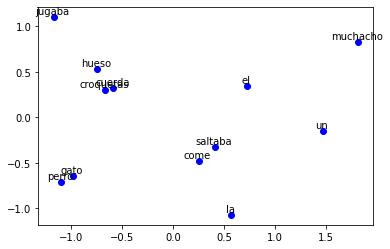

In [12]:
plot_words(C.T[:-2],label)

### Calculo de similitud

Para calcular la similitud entre vectores, se puede utilizar la distancia eculideana o bien el coseno. En NLP el coseno es una forma común de determinar la similitud entre vectores. Este se define como:

$$\cos(x,y) = \frac{x\cdot y}{||x|| ||y||}$$

Asimismo, para simplificar el calculo del coseno se pueden normalizar los vectores, dividiéndolos entre sus normas. Así, para cada vector $x$ su norma es $||x||=1$, lo que simplifica la ecuación anterior a:

$$\cos(x,y) = x\cdot y$$

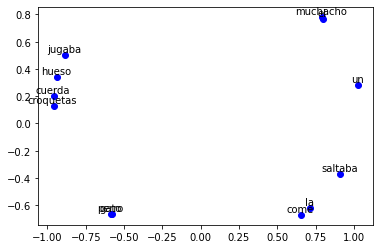

In [13]:
#Normalización de los vecotores
C_norm = (C/np.array([np.linalg.norm(w) for w in C.T])).T

#Ploteo
plot_words(C_norm[:-2],label)

In [14]:
#Palabra objetivo
obj_word = C_norm[idx['perro']]

#Búsqueda de palabras más similares
for w,v in idx.items():
    #Calcula la distancia coseno
    print(w,'\t', np.dot(C_norm[v], obj_word) )

el 	 -0.9821469818968306
perro 	 1.0
come 	 0.23550496400316517
un 	 -0.7419255233970662
hueso 	 0.43663547911684103
muchacho 	 -0.9844648782377584
jugaba 	 0.27663376882793483
saltaba 	 -0.15728413283504644
la 	 0.15775286409303904
cuerda 	 0.5566932040887257
croquetas 	 0.6176211750549216
gato 	 0.9999861338711057
<EOS> 	 0.6886874463487968
<BOS> 	 -0.7805839943288498


### Predicción de secuencias

Una aplicación típica de este tipo de modelos es la generación de secuencias; esto tiene aplicaciones, por ejemplo, en la predicción automática de texto, en agentes conversacionales, entre otras. La idea es introducir una secuencia inicial $x^{(1)},...,x^{(t)}$ y que se prediga los elementos subsecuentes. Esto de la forma siguiente:

$$\hat{y}^{(t+1)} = \arg\max_y p(y|x^{(1)},...,x^{(t)})$$

Donde $y$ son los posibles elementos de un alfabeto. En el siguiente estado, $t+2$, se querrá predecir un elemento que siga a la secuencia $x^{(1)},...,x^{(t)}, \hat{y}^{(t+1)}$, por lo que tenemos que calcular:

$$\hat{y}^{(t+2)} = \arg\max_y p(y|x^{(1)},...,x^{(t)}, \hat{y}^{(t+1)})$$

Es decir, el símbolo $\hat{y}^{(t+1)}$ será la entrada de la RNN en el estado siguiente. De manera general, queremos obtener:

$$\hat{y}^{(t+i)} = \arg\max_y p(y|x^{(1)},...,x^{(t)},\hat{y}^{(t+1)}, ..., \hat{y}^{(t+i-1)})$$

La secuencia terminará cuando $\hat{y}^{(t+i)} = EOS$ para alguna $i$.


In [15]:
def forward_prediction(sent):
    arg_idx = BOS_IDX
    words = []
    
    h, probs = forward(sent)
    arg_max = list(idx.keys())[list(idx.values()).index(np.argmax(probs[-1]))]
    words.append(arg_max)
    
    while arg_max != '<EOS>':
        h, probs = forward(arg_max,h)
        arg_max = list(idx.keys())[list(idx.values()).index(np.argmax(probs[-1]))]
        words.append(arg_max)    
        
    return sent + ' ' + ' '.join(words)

Definido esta función, podemos autocompletar sentencias:

In [29]:
print( forward_prediction('<BOS> un') )
print( forward_prediction('<BOS> perro saltaba la') )
print( forward_prediction('<BOS> el perro saltaba') )
print( forward_prediction('<BOS> el gato') )
print( forward_prediction('<BOS> el') )

<BOS> un gato come <EOS>
<BOS> perro saltaba la <EOS>
<BOS> el perro saltaba <EOS>
<BOS> el gato come <EOS>
<BOS> el perro come <EOS>


Otras aplicaciones de las RNN son la traducción automática, el etiquetado (a diferentes niveles), sistemas de voz a texto y de texto a voz, etc. Sin embargo, en la actualidad se utilizan arquitecturas más compejas, como LSTMs y capas de atención.

### Visualización de las celdas recurrentes

Las celdas recurrentes guardan información tanto de los vectores de entrada como de la red en estados anteriores. Estas celdas tienen información importante que le permite a la red decidir la distribución de salida en un estado dado. Algunos modelos de representación vectorial (word embeddings) han aprovechado la información aquí almacenada para producir vectores de palabraS; sistemas como CoVe toman en cuenta estas celdas para "contextualizar" los embeddings.

Lo primero que haremos es definir un función que, además de devolver la probabilidad de salida, regrese cada una de las celdas recursivas en cada estado $t$. Así, obtendremos una matriz $H$ donde cada renglon será una celda vanilla. Podemos definir esta matriz por sus renglones como:

$$H_{t} = g(Vh^{(t-1)} + Ux^{(t)} + b)$$

In [17]:
def get_cells(sent, h = np.zeros(cell_dim)):
    sent = sent.split()
    prob_tot = np.zeros((len(sent),N-1))
    #Guarda las celdas vanillas por cada estado
    H = np.zeros((len(sent), cell_dim))
    
    for t,w in enumerate(sent):
        #FORWARD
        #embedding
        x= C.T[idx[w]]
        #Unidad oculta
        act = np.dot(V,h) + np.dot(U,x) + b
        h = np.tanh(act)
        #add h
        H[t] = h

        #capa de salida
        preAct = np.exp(np.dot(W,h) + c)
        probs = preAct/preAct.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = probs
        
    return H, prob_tot 

Entonces, dada una cadena, se obtendrá una celda vanilla para cada palabra en la cadena. De esta forma, podemos pensar que esta celda representa a la palabra  y su historia (las palabras que lo anteceden). Podemos visualizarlos, entonces, en un espacio vectorial.

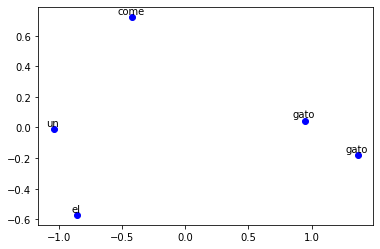

In [18]:
ex_sent = 'el gato come un gato'
H_s, p_s = get_cells(ex_sent)

plot_words(H_s,ex_sent.split())
plt.show()

Se puede ver cómo varían las celdas vanillas. Algunas de estas guardan cierta relación. Sin embargo, una interpretación precisa puede resultar complicada.

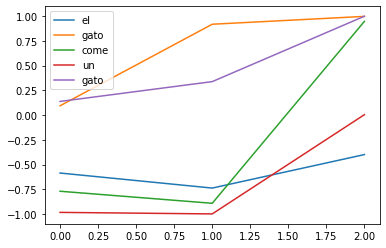

[[-0.58511047 -0.73715014 -0.39867304]
 [ 0.09435091  0.91857351  0.99802444]
 [-0.76924616 -0.89104545  0.94759988]
 [-0.98286294 -0.99837484  0.00459508]
 [ 0.13841691  0.33858277  0.99938554]]


In [19]:
plt.plot(H_s.T, '-')
plt.gca().legend(ex_sent.split())
plt.show()
print(H_s)